<a href="https://colab.research.google.com/github/SamChuah/Kaggle_exercise/blob/master/Kaggle_HeartDisease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install shap

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn 
from sklearn.model_selection import train_test_split #for data splitting
from torch.optim import optimizer as opt
from matplotlib import pyplot as plt 
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
import shap 

Check is GPU is available

In [3]:
torch.cuda.is_available()

True

Load data

In [4]:
dt = pd.read_csv('heart.csv')

Show examples of first 10 lines

In [5]:
dt.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [6]:
dt.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [7]:
dt.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

In [8]:
dt.columns

Index(['age', 'sex', 'chest_pain_type', 'resting_blood_pressure',
       'cholesterol', 'fasting_blood_sugar', 'rest_ecg',
       'max_heart_rate_achieved', 'exercise_induced_angina', 'st_depression',
       'st_slope', 'num_major_vessels', 'thalassemia', 'target'],
      dtype='object')

In [9]:
dt_old = dt

In [10]:
dt['sex'][dt_old['sex']==0] = 'female'
dt['sex'][dt_old['sex']==1] = 'male'

dt['chest_pain_type'][dt_old['chest_pain_type'] == 1] = 'typical angina'
dt['chest_pain_type'][dt_old['chest_pain_type'] == 2] = 'atypical angina'
dt['chest_pain_type'][dt_old['chest_pain_type'] == 3] = 'non-anginal pain'
dt['chest_pain_type'][dt_old['chest_pain_type'] == 4] = 'asymptomatic'

dt['fasting_blood_sugar'][dt_old['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
dt['fasting_blood_sugar'][dt_old['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

dt['rest_ecg'][dt_old['rest_ecg'] == 0] = 'normal'
dt['rest_ecg'][dt_old['rest_ecg'] == 1] = 'ST-T wave abnormality'
dt['rest_ecg'][dt_old['rest_ecg'] == 2] = 'left ventricular hypertrophy'

dt['exercise_induced_angina'][dt_old['exercise_induced_angina'] == 0] = 'no'
dt['exercise_induced_angina'][dt_old['exercise_induced_angina'] == 1] = 'yes'

dt['st_slope'][dt_old['st_slope'] == 1] = 'upsloping'
dt['st_slope'][dt_old['st_slope'] == 2] = 'flat'
dt['st_slope'][dt_old['st_slope'] == 3] = 'downsloping'

dt['thalassemia'][dt_old['thalassemia'] == 1] = 'normal'
dt['thalassemia'][dt_old['thalassemia'] == 2] = 'fixed defect'
dt['thalassemia'][dt_old['thalassemia'] == 3] = 'reversable defect'


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [11]:
dt.head(5)

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,male,non-anginal pain,145,233,greater than 120mg/ml,normal,150,no,2.3,0,0,normal,1
1,37,male,atypical angina,130,250,lower than 120mg/ml,ST-T wave abnormality,187,no,3.5,0,0,fixed defect,1
2,41,female,typical angina,130,204,lower than 120mg/ml,normal,172,no,1.4,flat,0,fixed defect,1
3,56,male,typical angina,120,236,lower than 120mg/ml,ST-T wave abnormality,178,no,0.8,flat,0,fixed defect,1
4,57,female,0,120,354,lower than 120mg/ml,ST-T wave abnormality,163,yes,0.6,flat,0,fixed defect,1


In [12]:
dt = pd.get_dummies(dt, drop_first=True)

In [13]:
dt.head(5)

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,target,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,fasting_blood_sugar_lower than 120mg/ml,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,exercise_induced_angina_yes,st_slope_flat,st_slope_upsloping,thalassemia_fixed defect,thalassemia_normal,thalassemia_reversable defect
0,63,145,233,150,2.3,0,1,1,0,1,0,0,0,1,0,0,0,0,1,0
1,37,130,250,187,3.5,0,1,1,1,0,0,1,0,0,0,0,0,1,0,0
2,41,130,204,172,1.4,0,1,0,0,0,1,1,0,1,0,1,0,1,0,0
3,56,120,236,178,0.8,0,1,1,0,0,1,1,0,0,0,1,0,1,0,0
4,57,120,354,163,0.6,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0


In [14]:
trainX, testX, trainY, testY = train_test_split(dt.drop('target', 1), dt['target'], test_size = .2, random_state=10) #split the data

In [15]:
trainX = torch.tensor(np.array(trainX), dtype=torch.float32).cuda()
trainY = torch.tensor(np.array(trainY), dtype=torch.float32).cuda()
testX = torch.tensor(np.array(testX), dtype=torch.float32).cuda()
testY = torch.tensor(np.array(testY), dtype=torch.float32).cuda()

In [16]:
class myModel(nn.Module):
  def __init__(self):
    super(myModel, self).__init__()

    self.model = nn.Sequential(nn.Linear(19, 32, bias=False), #layer 1
                                nn.BatchNorm1d(32),
                                nn.ReLU(inplace=True),
                                nn.Linear(32, 1, bias=True))
    
  def forward(self, x):
    y = self.model(x)
    #y = nn.functional.softmax(y, dim=1)
    #_, y_logit = torch.max(y, dim=1)
    return torch.sigmoid(y)


In [17]:
model = myModel()

In [18]:
learning_rate = 1e-3
epochs = 300
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
loss_fn = torch.nn.BCELoss(reduction='mean')
model = model.cuda()
train_loss = []
test_loss = []

Train the network

In [19]:
for t in range(epochs):
    model.train()
    # Forward pass: compute predicted y by passing x to the model.
    predY = model(trainX)

    # Compute and print loss.
    loss = loss_fn(predY, trainY.unsqueeze(1))
    train_loss.append(loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
    
    # testing 
    model.eval()

    with torch.no_grad():
        # Forward pass: compute predicted y by passing x to the model.
        predY = model(testX)

        # Compute and print loss.
        loss = loss_fn(predY, testY.unsqueeze(1))
        test_loss.append(loss.item())

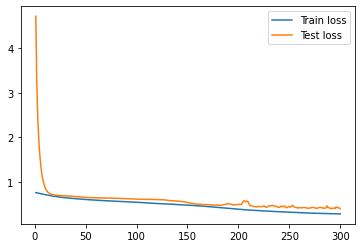

In [20]:
plt.plot(torch.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(torch.arange(1, len(test_loss)+1), test_loss, label='Test loss')
plt.legend()

In [21]:
testY = testY.cpu().numpy()
predY = predY.cpu().numpy().squeeze(1)

In [22]:
confusion_matrix = confusion_matrix(testY, predY.round())
confusion_matrix

array([[28,  7],
       [ 4, 22]])

In [23]:
total=sum(sum(confusion_matrix))

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
print('Sensitivity : ', sensitivity )

specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
print('Specificity : ', specificity)

Sensitivity :  0.875
Specificity :  0.7586206896551724


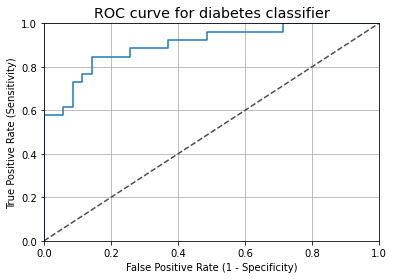

In [24]:
fpr, tpr, thresholds = roc_curve(testY, predY)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

Another common metric is the Area Under the Curve, or AUC. This is a convenient way to capture the performance of a model in a single number, although it's not without certain issues. As a rule of thumb, an AUC can be classed as follows,

*   0.90 - 1.00 = excellent
*   0.80 - 0.90 = good
*0.70 - 0.80 = fair
*0.60 - 0.70 = poor
*0.50 - 0.60 = fail

Let's see what the above ROC gives us,

In [25]:
auc(fpr, tpr)

0.9021978021978022

Explanation using Shapley Values

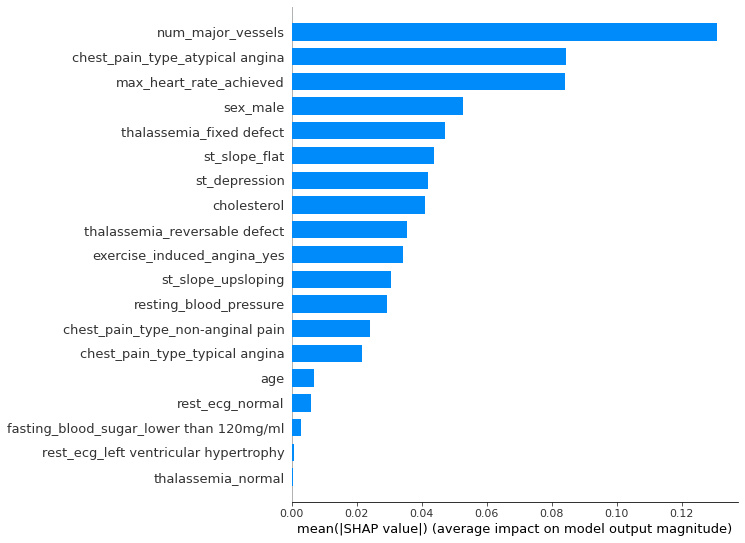

In [26]:
explainer = shap.DeepExplainer(model, testX)
shap_values = explainer.shap_values(testX)
feature_names = dt.columns[dt.columns != 'target']
shap.summary_plot(shap_values, testX, feature_names=feature_names, plot_type="bar")

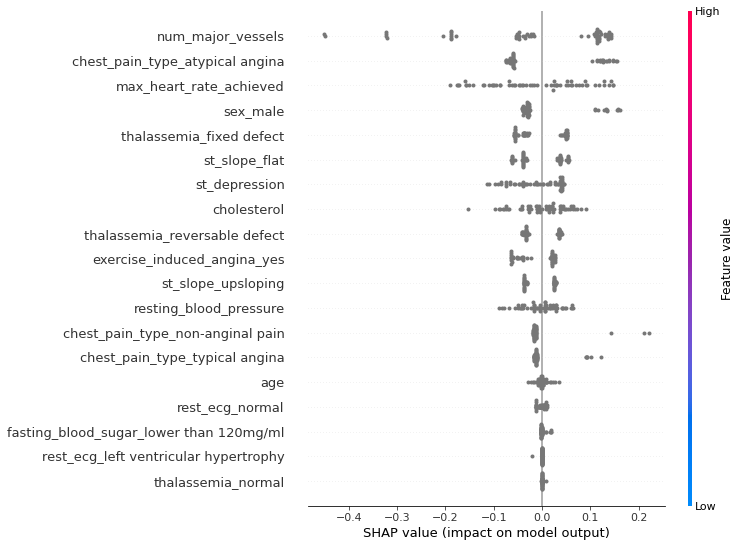

In [27]:
shap.summary_plot(shap_values, testX, feature_names)